In [3]:
import sys

In [4]:
sys.path.insert(0, '/home/joe2/Documents/LambdaSchool/labs_ir/repos/Data-Science/data')

In [5]:
sys.path

['/home/joe2/Documents/LambdaSchool/labs_ir/repos/Data-Science/data',
 '',
 '/home/joe2/anaconda3/envs/riskylobster/lib/python36.zip',
 '/home/joe2/anaconda3/envs/riskylobster/lib/python3.6',
 '/home/joe2/anaconda3/envs/riskylobster/lib/python3.6/lib-dynload',
 '/home/joe2/anaconda3/envs/riskylobster/lib/python3.6/site-packages',
 '/home/joe2/anaconda3/envs/riskylobster/lib/python3.6/site-packages/IPython/extensions',
 '/home/joe2/.ipython']

In [6]:
sys.path.remove('')

In [6]:
from fin_data import DailyTimeSeries
from fracdiff import FractionalDifferentiation as fd

import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import ModelCheckpoint 

    
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

Using TensorFlow backend.


In [13]:
def generate_df_fracdiff_target(symbol, return_type='generator', shift=1):
    # Ininialize class
    dts = DailyTimeSeries(symbol)
    df = dts.initiate()
    funs = ['totalrevenue',  'totalcostofrevenue', 'totalgrossprofit', 'totalpretaxincome', 'weightedavebasicdilutedsharesos', 'cashdividendspershare']
    techs = ['SMA', 'WMA', 'STOCH', 'ROC', 'AROON']
    macros = ['housing_index', 'confidence_index', 'trade_index', 'longterm_rates', 'shortterm_rates']
    df = dts.add_fundamentals(df, funs)
    df = dts.add_technicals(techs, df)
    df = dts.add_macro(df, macros)
    todrop = []
    for col in df.columns:
        if df[col].isnull().sum()/len(df) >  .25:
            print('{} is missing '.format(col), df[col].isnull().sum())
            print('{} dropped'.format(col))
            todrop.append(col)

    df = df.drop(labels=todrop, axis=1)
    df = df.dropna(axis=0)
    
    if str(symbol + '_adjusted_close') in df.columns:
        df['target'] = fd.frac_diff_ffd(df[[str(symbol + '_adjusted_close')]], .35).shift(-1)[str(symbol + '_adjusted_close')]
    else:
        df['target'] = fd.frac_diff_ffd(df[[str(symbol + '_close')]], .35).shift(-1)[str(symbol + '_close')]

    df = df.dropna()
    X = df.drop(columns='target')
    y = df[['target']].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.8, 
                                                    shuffle=False)

    scaler = MinMaxScaler()
    scaler.fit(X_train)


    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    if return_type == 'generator':
        train_data_generator = TimeseriesGenerator(X_train, y_train, 
                                           length=30,
                                           sampling_rate=1, 
                                           stride=1, 
                                           batch_size=30)

        test_data_generator = TimeseriesGenerator(X_test, y_test, 
                                                  length=30, 
                                                  sampling_rate=1,
                                                  stride=1,
                                                  batch_size=30)
        
        return(train_data_generator, test_data_generator)
    
    elif return_type == 'Xy_trte':
        return(X_train, X_test, y_train, y_test)
    
    elif return_type == 'df':
        return(df)
    else:
        return(df)


In [8]:
X_train, X_test, y_train, y_test = generate_df_fracdiff_target('TSLA')

################################################################### 
 Ticker:  TSLA 
 Last Refreshed:  2019-09-10 
 Data Retrieved:  Daily Time Series with Splits and Dividend Events 
 ###################################################################
################################################################### 
 Ticker:  TSLA 
 Fundamentals Retrieved:  ['TSLA_open' 'TSLA_high' 'TSLA_low' 'TSLA_close' 'TSLA_adjusted_close'
 'TSLA_volume' 'TSLA_dividend_amount' 'TSLA_totalrevenue'
 'TSLA_totalcostofrevenue' 'TSLA_totalgrossprofit'
 'TSLA_totalpretaxincome' 'TSLA_weightedavebasicdilutedsharesos'
 'TSLA_cashdividendspershare'] 
 ###################################################################
################################################################### 
 Ticker:  TSLA 
 Retrieved Data Start Date:  2011-11-14 
 Retrieved Data End Date:  2019-07-29 
 Data Retrieved:  ['TSLA_totalrevenue', 'TSLA_totalcostofrevenue', 'TSLA_totalgrossprofit', 'TSLA_totalpretaxincome', 'TSLA_w

/home/joe2/Documents/LambdaSchool/labs_ir/repos/Data-Science/data/fin_data.py:295: UserWarning: The latest value available for Housing Index is from January 2019.
  warnings.warn("The latest value available for Housing Index is from January 2019.")


################################################################### 
 Index: Yale Investor Behavior Project Added 
 ###################################################################
################################################################### 
 Trade Weighted U.S. Dollar Index: Broad Added 
 ###################################################################
################################################################### 
 US Treasury Bond Long-Term Rates Added 
 ###################################################################
################################################################### 
 US Treasury Bond Short-Term Rates Added 
 ###################################################################
8_Wk_DR is missing  2070
8_Wk_DR dropped
8_Wk_CE is missing  2070
8_Wk_CE dropped


/home/joe2/Documents/LambdaSchool/labs_ir/repos/Data-Science/data/fin_data.py:336: UserWarning: Contains Null Values
  warnings.warn("Contains Null Values")


In [9]:
train_data_generator = TimeseriesGenerator(X_train, y_train, 
                                           length=30,
                                           sampling_rate=1, 
                                           stride=1, 
                                           batch_size=30)

test_data_generator = TimeseriesGenerator(X_test, y_test, 
                                          length=30, 
                                          sampling_rate=1,
                                          stride=1,
                                          batch_size=30)

In [12]:
tsla_df = generate_df_fracdiff_target('TSLA', return_type='df')

################################################################### 
 Ticker:  TSLA 
 Last Refreshed:  2019-09-10 
 Data Retrieved:  Daily Time Series with Splits and Dividend Events 
 ###################################################################
################################################################### 
 Ticker:  TSLA 
 Fundamentals Retrieved:  ['TSLA_open' 'TSLA_high' 'TSLA_low' 'TSLA_close' 'TSLA_adjusted_close'
 'TSLA_volume' 'TSLA_dividend_amount' 'TSLA_totalrevenue'
 'TSLA_totalcostofrevenue' 'TSLA_totalgrossprofit'
 'TSLA_totalpretaxincome' 'TSLA_weightedavebasicdilutedsharesos'
 'TSLA_cashdividendspershare'] 
 ###################################################################
################################################################### 
 Ticker:  TSLA 
 Retrieved Data Start Date:  2011-11-14 
 Retrieved Data End Date:  2019-07-29 
 Data Retrieved:  ['TSLA_totalrevenue', 'TSLA_totalcostofrevenue', 'TSLA_totalgrossprofit', 'TSLA_totalpretaxincome', 'TSLA_w

/home/joe2/Documents/LambdaSchool/labs_ir/repos/Data-Science/data/fin_data.py:295: UserWarning: The latest value available for Housing Index is from January 2019.
  warnings.warn("The latest value available for Housing Index is from January 2019.")


################################################################### 
 Index: Yale Investor Behavior Project Added 
 ###################################################################
################################################################### 
 Trade Weighted U.S. Dollar Index: Broad Added 
 ###################################################################
################################################################### 
 US Treasury Bond Long-Term Rates Added 
 ###################################################################
################################################################### 
 US Treasury Bond Short-Term Rates Added 
 ###################################################################
8_Wk_DR is missing  2070
8_Wk_DR dropped
8_Wk_CE is missing  2070
8_Wk_CE dropped


/home/joe2/Documents/LambdaSchool/labs_ir/repos/Data-Science/data/fin_data.py:336: UserWarning: Contains Null Values
  warnings.warn("Contains Null Values")


In [15]:
tsla_df.head()

,TSLA_open,TSLA_high,TSLA_low,TSLA_close,TSLA_adjusted_close,TSLA_volume,TSLA_dividend_amount,TSLA_totalrevenue,TSLA_totalcostofrevenue,TSLA_totalgrossprofit,TSLA_totalpretaxincome,TSLA_weightedavebasicdilutedsharesos,TSLA_cashdividendspershare,TSLA_SMA,TSLA_WMA,TSLA_SlowK,TSLA_SlowD,TSLA_ROC,TSLA_Aroon Down,TSLA_Aroon Up,housing_index,conf_index,conf_index_SE,trade_value,10 Yrs Rates,20-Yr Maturity Rate,4_Wk_DR,4_Wk_CE,13_Wk_DR,13_Wk_CE,26_Wk_DR,26_Wk_CE,52_Wk_DR,52_Wk_CE,target
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-10-24,338.80,342.80,336.16,337.34,337.34,4491700.0,0.0,2.298436e+09,1.661701e+09,636735000.0,30011000.0,145900000.0,0.0,349.0105,349.5144,3.7826,17.7706,-2.2911,25.0,80.0,195.015,41.62,3.75,119.6582,2.78,2.70,0.99,1.00,1.10,1.12,1.25,1.28,1.39,1.42,11.273610
2017-10-25,336.70,337.50,323.56,325.84,325.84,8594100.0,0.0,2.298436e+09,1.661701e+09,636735000.0,30011000.0,145900000.0,0.0,348.2540,347.3077,4.6878,6.8576,-4.4373,100.0,75.0,195.015,41.62,3.75,120.2424,2.81,2.72,0.99,1.00,1.10,1.12,1.25,1.28,1.39,1.42,16.417419
2017-10-26,327.78,330.23,323.20,326.17,326.17,5023500.0,0.0,2.298436e+09,1.661701e+09,636735000.0,30011000.0,145900000.0,0.0,347.5825,345.2045,6.8861,5.1188,-3.9547,100.0,70.0,195.015,41.62,3.75,120.2424,2.82,2.74,0.97,0.98,1.09,1.11,1.26,1.29,1.39,1.42,12.843449
2017-10-27,319.75,324.59,316.66,320.87,320.87,6979700.0,0.0,2.298436e+09,1.661701e+09,636735000.0,30011000.0,145900000.0,0.0,346.5710,342.6604,9.6362,7.0700,-5.9308,100.0,65.0,195.015,41.62,3.75,120.2424,2.79,2.71,0.96,0.97,1.08,1.10,1.25,1.28,1.38,1.41,14.978676
2017-10-30,319.18,323.78,317.25,320.08,320.08,4254400.0,0.0,2.298436e+09,1.661701e+09,636735000.0,30011000.0,145900000.0,0.0,345.4985,340.1375,11.7345,9.4189,-6.2806,95.0,60.0,195.015,41.62,3.75,120.2424,2.74,2.66,0.94,0.95,1.10,1.12,1.22,1.24,1.38,1.41,28.060391


In [16]:
tsla_df.head()

,TSLA_open,TSLA_high,TSLA_low,TSLA_close,TSLA_adjusted_close,TSLA_volume,TSLA_dividend_amount,TSLA_totalrevenue,TSLA_totalcostofrevenue,TSLA_totalgrossprofit,TSLA_totalpretaxincome,TSLA_weightedavebasicdilutedsharesos,TSLA_cashdividendspershare,TSLA_SMA,TSLA_WMA,TSLA_SlowK,TSLA_SlowD,TSLA_ROC,TSLA_Aroon Down,TSLA_Aroon Up,housing_index,conf_index,conf_index_SE,trade_value,10 Yrs Rates,20-Yr Maturity Rate,4_Wk_DR,4_Wk_CE,13_Wk_DR,13_Wk_CE,26_Wk_DR,26_Wk_CE,52_Wk_DR,52_Wk_CE,target
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-10-24,338.80,342.80,336.16,337.34,337.34,4491700.0,0.0,2.298436e+09,1.661701e+09,636735000.0,30011000.0,145900000.0,0.0,349.0105,349.5144,3.7826,17.7706,-2.2911,25.0,80.0,195.015,41.62,3.75,119.6582,2.78,2.70,0.99,1.00,1.10,1.12,1.25,1.28,1.39,1.42,11.273610
2017-10-25,336.70,337.50,323.56,325.84,325.84,8594100.0,0.0,2.298436e+09,1.661701e+09,636735000.0,30011000.0,145900000.0,0.0,348.2540,347.3077,4.6878,6.8576,-4.4373,100.0,75.0,195.015,41.62,3.75,120.2424,2.81,2.72,0.99,1.00,1.10,1.12,1.25,1.28,1.39,1.42,16.417419
2017-10-26,327.78,330.23,323.20,326.17,326.17,5023500.0,0.0,2.298436e+09,1.661701e+09,636735000.0,30011000.0,145900000.0,0.0,347.5825,345.2045,6.8861,5.1188,-3.9547,100.0,70.0,195.015,41.62,3.75,120.2424,2.82,2.74,0.97,0.98,1.09,1.11,1.26,1.29,1.39,1.42,12.843449
2017-10-27,319.75,324.59,316.66,320.87,320.87,6979700.0,0.0,2.298436e+09,1.661701e+09,636735000.0,30011000.0,145900000.0,0.0,346.5710,342.6604,9.6362,7.0700,-5.9308,100.0,65.0,195.015,41.62,3.75,120.2424,2.79,2.71,0.96,0.97,1.08,1.10,1.25,1.28,1.38,1.41,14.978676
2017-10-30,319.18,323.78,317.25,320.08,320.08,4254400.0,0.0,2.298436e+09,1.661701e+09,636735000.0,30011000.0,145900000.0,0.0,345.4985,340.1375,11.7345,9.4189,-6.2806,95.0,60.0,195.015,41.62,3.75,120.2424,2.74,2.66,0.94,0.95,1.10,1.12,1.22,1.24,1.38,1.41,28.060391


In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter

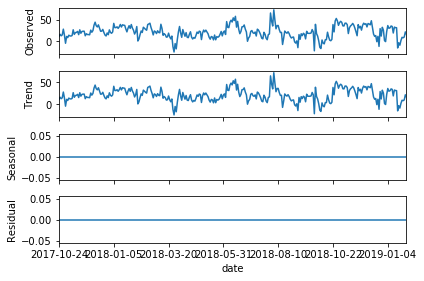

In [26]:
seasonal_decompose(tsla_df[['target']], model='addative', freq=1).plot()
plt.show()

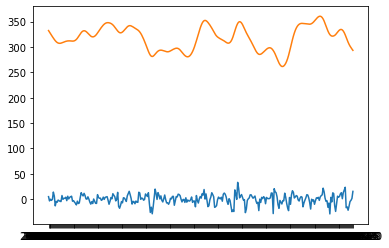

In [37]:
filtered = hpfilter(tsla_df['TSLA_adjusted_close'], 100)[0]
plt.plot(filtered)
plt.plot(tsla_df['TSLA_adjusted_close']-filtered)

In [39]:
import pyhht

2
3
4
5
6


<Figure size 1440x864 with 0 Axes>

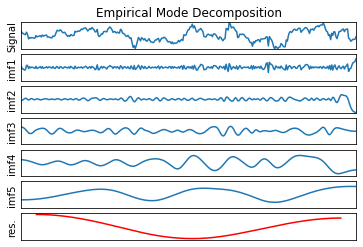

In [44]:
plt.figure(figsize=(20,12))

decomposer = pyhht.EMD(tsla_df['TSLA_adjusted_close'])
imfs = decomposer.decompose()
pyhht.visualization.plot_imfs(tsla_df['TSLA_adjusted_close'].values, imfs, tsla_df['TSLA_adjusted_close'].index)

In [49]:
imfs

array([[  5.43889784,  -6.29122576,  -6.43182682, ...,  22.41407474,
         25.59808914,  37.81951423],
       [ -5.48880815,  -4.44569416,  -1.72019482, ..., -54.47811644,
        -56.7723174 , -57.82296897],
       [ 17.1336036 ,  16.72489471,  14.97042551, ...,  -0.67802921,
         -0.822587  ,  -0.83312105],
       [ 14.21127059,  13.80904744,  13.2860025 , ..., -31.23781407,
        -30.79674227, -30.50645137],
       [-22.29618745, -22.30219091, -22.27801088, ...,  36.08230664,
         35.97312445,  35.83467693],
       [328.34122357, 328.34516869, 328.34360452, ..., 324.27757833,
        324.28043308, 324.27835024]])

In [48]:
tsla_df.shape

(318, 35)

In [1]:
import dill

In [51]:
dill.dump_session('test_dump.db')

In [7]:
dill.load_session('test_dump.db')

Using TensorFlow backend.


KeyError: 'ClassType'